In [1]:
import matplotlib.pyplot as plt
import numpy as np
from data.alphadigits import BinaryAlphaDigitsDataset
from data.mnist import MNISTDataset
from torch.utils.data import DataLoader

In [2]:
restrict_labels = ['a', 'b', 'c', 'd']
input_size = 320 

## RBM

In [3]:
from principal_RBM_alpha import init_RBM, train_RBM, generer_image_RBM

100%|██████████| 1001/1001 [00:06<00:00, 143.76it/s]


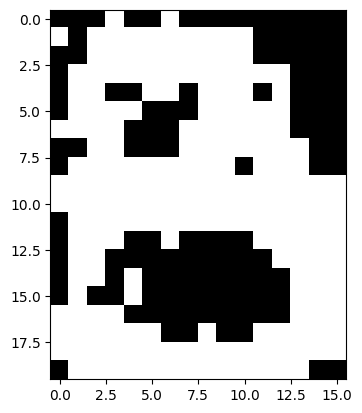

In [4]:
rbm = init_RBM(input_size, 100)
rbm = train_RBM(rbm, epochs=1001,
                ds=BinaryAlphaDigitsDataset(restrict_labels=restrict_labels))
generer_image_RBM(rbm, num_iterations=500, num_images=1)

## DBN

In [4]:
from principal_DBN_alpha import init_DBN, train_DBN, generer_image_DBN

Training RBM 1


100%|██████████| 1000/1000 [00:08<00:00, 113.26it/s]


Training RBM 2


100%|██████████| 1000/1000 [00:01<00:00, 914.54it/s]


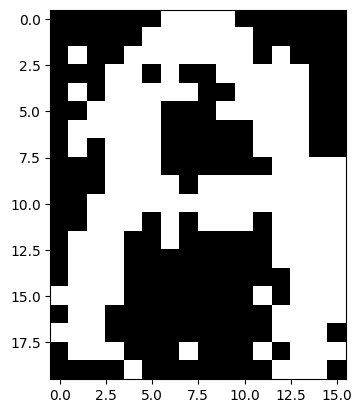

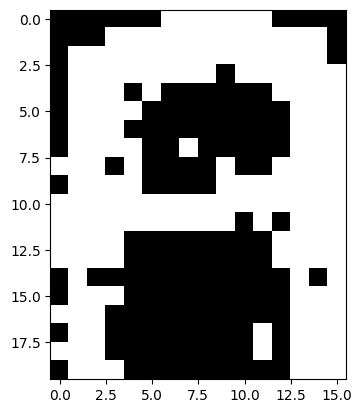

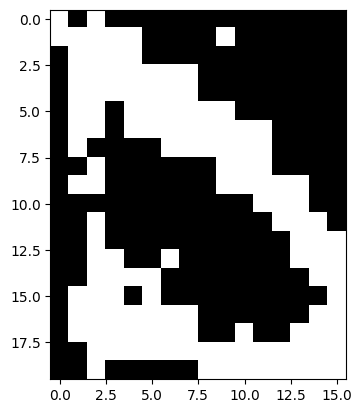

In [5]:
dbn = init_DBN([input_size, 100, 50])
dbn = train_DBN(dbn, 1000, 1e-1, 32, 
                ds=BinaryAlphaDigitsDataset(restrict_labels=restrict_labels,
                                            mode='train'))
generer_image_DBN(dbn, 301, 3)

# DNN

In [5]:
from principal_DNN_MNIST import init_DNN, entree_sortie_reseau, pretrain_DNN, retropropagation

input_size = 784 # 28 * 28
output_size = 10 # 10 numbers

In [15]:
dnn = init_DNN([input_size]+[200]*3+[output_size])
dnn = pretrain_DNN(
    dnn, 
    num_iterations=100, 
    learning_rate=1e-1,
    batch_size=1000, 
    ds=MNISTDataset(mode='train')
    )

Training DBN 1
100%|██████████| 100/100 [07:15<00:00,  4.36s/it]
Training DBN 2
100%|██████████| 100/100 [02:55<00:00,  1.75s/it]
Training DBN 3
100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


In [6]:
def test_DNN(dnn, ds):
    data = ds.data
    data = data.reshape((data.shape[0], -1))
    labels = ds.labels
    logits = entree_sortie_reseau(dnn, data)[-1]
    predictions = np.argmax(logits, axis=1)
    error_rate = np.mean(predictions != labels)
    return error_rate

In [9]:
log_frequency = 10
n_epochs = 50

test_accuracy = list()
for epoch in range(n_epochs+1):
    dnn = retropropagation(dnn, num_iterations=1, learning_rate=1e-1,
                       batch_size=1000, ds=MNISTDataset(mode='train'),
                       print_result=epoch%log_frequency==0)
    
    error_rate = test_DNN(dnn, ds=MNISTDataset(mode='test'))
    test_accuracy.append(100-error_rate*100)

    if epoch%log_frequency==0:
        print(f"Epoch {epoch}: test accuracy {test_accuracy[-1]}")

Retropropagation @ epoch 0: loss 1.24
Epoch 0: test accuracy 87.89
Retropropagation @ epoch 0: loss 0.29
Epoch 10: test accuracy 92.87
Retropropagation @ epoch 0: loss 0.24
Epoch 20: test accuracy 93.82
Retropropagation @ epoch 0: loss 0.21
Epoch 30: test accuracy 94.27
Retropropagation @ epoch 0: loss 0.20
Epoch 40: test accuracy 94.56
Retropropagation @ epoch 0: loss 0.18
Epoch 50: test accuracy 94.88


## V.2 Analyse

### V.2.a Influence du nombre de couches

In [16]:
## With pretraining

results_1 = []
archis = [
    [100],
    [100, 100, 100],
    [100, 100, 100, 100, 100], 
    ]

for archi in archis:
    print('Testing architecture', archi)

    dnn = init_DNN([input_size] + archi + [output_size])
    
    dnn = pretrain_DNN(
        dnn, 
        num_iterations=100, 
        learning_rate=1e-1,
        batch_size=1000, 
        ds=MNISTDataset(mode='train')
        )
    
    dnn = retropropagation(
        dnn, 
        num_iterations=50, 
        learning_rate=1e-1,
        batch_size=1000, 
        ds=MNISTDataset(mode='train'),
        print_result=False
        )
        
    error_rate = test_DNN(dnn, ds=MNISTDataset(mode='test'))
    acc = 100-error_rate*100
    print('For architecture', archi, "accuracy", acc)

    results_1.append(acc)

Testing architecture [100]
Training RBM 1


100%|██████████| 100/100 [05:28<00:00,  3.28s/it]


For architecture [100] accuracy 92.14
Testing architecture [100, 100, 100]
Training RBM 1


100%|██████████| 100/100 [04:56<00:00,  2.96s/it]


Training RBM 2


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


Training RBM 3


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


For architecture [100, 100, 100] accuracy 93.4
Testing architecture [100, 100, 100, 100, 100]
Training RBM 1


100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


Training RBM 2


100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


Training RBM 3


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


Training RBM 4


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Training RBM 5


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


For architecture [100, 100, 100, 100, 100] accuracy 93.28


In [17]:
## Without pretraining

results_2 = []
archis = [
    [100],
    [100, 100, 100],
    [100, 100, 100, 100, 100], 
    ]

for archi in archis:
    print('Testing architecture', archi)

    dnn = init_DNN([input_size] + archi + [output_size])
    
    dnn = retropropagation(
        dnn, 
        num_iterations=50, 
        learning_rate=1e-1,
        batch_size=1000, 
        ds=MNISTDataset(mode='train'),
        print_result=False
        )
        
    error_rate = test_DNN(dnn, ds=MNISTDataset(mode='test'))
    acc = 100-error_rate*100
    print('For architecture', archi, "accuracy", acc)

    results_2.append(acc)

Testing architecture [100]
For architecture [100] accuracy 91.43
Testing architecture [100, 100, 100]
For architecture [100, 100, 100] accuracy 11.350000000000009
Testing architecture [100, 100, 100, 100, 100]
For architecture [100, 100, 100, 100, 100] accuracy 11.350000000000009


In [19]:
results_1, results_2

([92.14, 93.4, 93.28], [91.43, 11.350000000000009, 11.350000000000009])

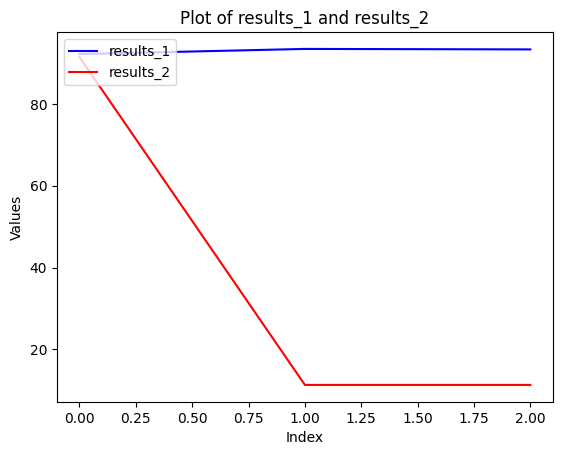

In [18]:
plt.figure()
plt.plot(range(len(results_1)), results_1, color='blue', label='results_1')
plt.plot(range(len(results_1)), results_2, color='red', label='results_2')

plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of results_1 and results_2')

plt.show()

It looks like the optimal number of layers is 3

### V.2.b.  Influence de la taille des couches

In [20]:
## With pretraining

results_3 = []
archis = [
    [100, 100], 
    [300, 300,],
    [500, 500], 
    [700, 700], 
    ]

for archi in archis:
    print('Testing architecture', archi)

    dnn = init_DNN([input_size] + archi + [output_size])
    
    dnn = pretrain_DNN(
        dnn, 
        num_iterations=100, 
        learning_rate=1e-1,
        batch_size=1000, 
        ds=MNISTDataset(mode='train')
        )
    
    dnn = retropropagation(
        dnn, 
        num_iterations=50, 
        learning_rate=1e-1,
        batch_size=1000, 
        ds=MNISTDataset(mode='train'),
        print_result=False
        )
        
    error_rate = test_DNN(dnn, ds=MNISTDataset(mode='test'))
    acc = 100-error_rate*100
    print('For architecture', archi, "accuracy", acc)

    results_3.append(acc)

Testing architecture [100, 100]
Training RBM 1


100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


Training RBM 2


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


For architecture [100, 100] accuracy 93.04
Testing architecture [300, 300]
Training RBM 1


100%|██████████| 100/100 [07:28<00:00,  4.49s/it]


Training RBM 2


100%|██████████| 100/100 [03:51<00:00,  2.32s/it]


For architecture [300, 300] accuracy 95.2
Testing architecture [500, 500]
Training RBM 1


100%|██████████| 100/100 [10:12<00:00,  6.13s/it]


Training RBM 2


100%|██████████| 100/100 [07:19<00:00,  4.40s/it]


For architecture [500, 500] accuracy 95.98
Testing architecture [700, 700]
Training RBM 1


100%|██████████| 100/100 [12:15<00:00,  7.35s/it]


Training RBM 2


100%|██████████| 100/100 [10:36<00:00,  6.37s/it]


For architecture [700, 700] accuracy 95.76


In [21]:
## Without pretraining

results_4 = []
archis = [
    [100, 100], 
    [300, 300,],
    [500, 500], 
    [700, 700], 
    ]

for archi in archis:
    print('Testing architecture', archi)

    dnn = init_DNN([input_size] + archi + [output_size])
    
    dnn = retropropagation(
        dnn, 
        num_iterations=50, 
        learning_rate=1e-1,
        batch_size=1000, 
        ds=MNISTDataset(mode='train'),
        print_result=False
        )
        
    error_rate = test_DNN(dnn, ds=MNISTDataset(mode='test'))
    acc = 100-error_rate*100
    print('For architecture', archi, "accuracy", acc)

    results_4.append(acc)

Testing architecture [100, 100]
For architecture [100, 100] accuracy 17.849999999999994
Testing architecture [300, 300]
For architecture [300, 300] accuracy 74.6
Testing architecture [500, 500]
For architecture [500, 500] accuracy 80.37
Testing architecture [700, 700]
For architecture [700, 700] accuracy 8.919999999999987


In [23]:
results_3, results_4

([93.04, 95.2, 95.98, 95.76],
 [17.849999999999994, 74.6, 80.37, 8.919999999999987])

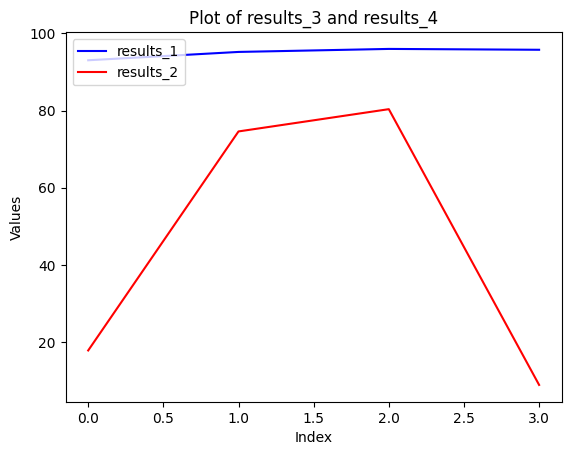

In [24]:
plt.figure()
plt.plot(range(len(results_3)), results_3, color='blue', label='results_1')
plt.plot(range(len(results_3)), results_4, color='red', label='results_2')

plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of results_3 and results_4')

plt.show()

It looks like the optimal units of hidden layers is 300 

### V.2.c. Influence de la taille de la base

In [8]:
## With pretraining only

results_5 = []
sizes = [1000, 5000, 10000, 20000, 30000, 50000]


for size in sizes:
    print('Testing size', size)

    dnn = init_DNN([input_size] + [100, 100, 100] + [output_size])
    
    dnn = pretrain_DNN(
        dnn, 
        num_iterations=100, 
        learning_rate=1e-1,
        batch_size=1000, 
        ds=MNISTDataset(mode='train', size=size)
        )
    
    dnn = retropropagation(
        dnn, 
        num_iterations=50, 
        learning_rate=1e-1,
        batch_size=1000, 
        ds=MNISTDataset(mode='train', size=size),
        print_result=False
        )
        
    error_rate = test_DNN(dnn, ds=MNISTDataset(mode='test'))
    acc = 100-error_rate*100
    print('For size', size, "accuracy", acc)

    results_5.append(acc)

Testing size 1000
Training RBM 1


100%|██████████| 100/100 [00:06<00:00, 14.59it/s]


Training RBM 2


100%|██████████| 100/100 [00:02<00:00, 45.93it/s]


Training RBM 3


100%|██████████| 100/100 [00:02<00:00, 46.99it/s]


For size 1000 accuracy 9.799999999999997
Testing size 5000
Training RBM 1


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Training RBM 2


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


Training RBM 3


100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


For size 5000 accuracy 9.799999999999997
Testing size 10000
Training RBM 1


100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Training RBM 2


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


Training RBM 3


100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


For size 10000 accuracy 21.099999999999994
Testing size 20000
Training RBM 1


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


Training RBM 2


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Training RBM 3


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


For size 20000 accuracy 40.46999999999999
Testing size 30000
Training RBM 1


100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


Training RBM 2


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training RBM 3


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


For size 30000 accuracy 50.480000000000004
Testing size 50000
Training RBM 1


100%|██████████| 100/100 [05:17<00:00,  3.18s/it]


Training RBM 2


100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Training RBM 3


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


For size 50000 accuracy 84.3


In [9]:
results_5

[9.799999999999997,
 9.799999999999997,
 21.099999999999994,
 40.46999999999999,
 50.480000000000004,
 84.3]

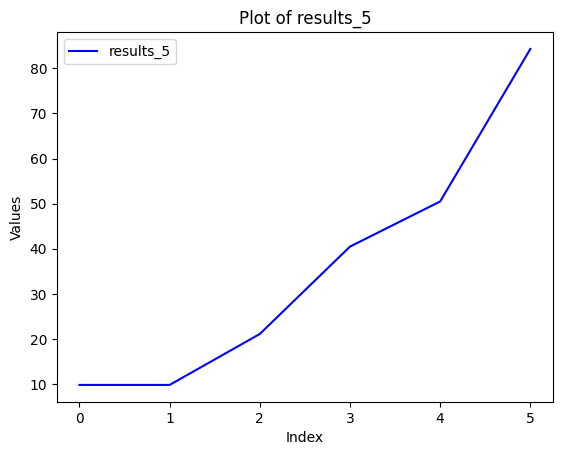

In [10]:
plt.figure()
plt.plot(range(len(results_5)), results_5, color='blue', label='results_5')

plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of results_5')

plt.show()

The larger the training database, the better

### V.2.d. Entrainement complet en configuration optimale

Test on 3 layers of 300 units with more retropropagation steps

In [18]:
## With pretraining

dnn = init_DNN([input_size] + [300, 300, 300] + [output_size])

dnn = pretrain_DNN(
    dnn, 
    num_iterations=100, 
    learning_rate=1e-1,
    batch_size=1000, 
    ds=MNISTDataset(mode='train')
    )

dnn = retropropagation(
    dnn, 
    num_iterations=150, 
    learning_rate=1e-1,
    batch_size=1000, 
    ds=MNISTDataset(mode='train'),
    print_result=False
    )
        
error_rate = test_DNN(dnn, ds=MNISTDataset(mode='test'))
acc = 100-error_rate*100
print('For optimal configuration', "accuracy", acc)

Training RBM 1
100%|██████████| 100/100 [05:17<00:00,  3.18s/it]
Training RBM 2
100%|██████████| 100/100 [01:11<00:00,  1.39it/s]
Training RBM 3
100%|██████████| 100/100 [01:03<00:00,  1.56it/s]

For optimal configuration accuracy 96.79

